In [58]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
import keras.backend as K
from keras.utils import load_img
import glob
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.metrics import Accuracy
import keras
from keras import Model
from tensorflow import GradientTape
from tensorflow.math import l2_normalize
from tensorflow.random import uniform

In [2]:
bad = glob.glob('bad_quality/*')
good = glob.glob('good_quality/*')

In [3]:
len(bad), len(good)

(951, 1125)

In [4]:
bad_images = []
good_images = []
targets = []
target_size = (150,150)
for path in bad:
    img = load_img(path, target_size=target_size)
    bad_images.append(np.asarray(img))
    targets.append(0)
    
for path in good:
    img = load_img(path, target_size=target_size)
    bad_images.append(np.asarray(img))
    targets.append(1)

In [5]:
X = np.asarray(bad_images + good_images)/255
y = np.asarray(targets)

x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True, random_state=123)

In [6]:
inputs = layers.Input(shape=target_size + (3,))

x = layers.Conv2D(16, 3, padding='same', activation='relu')(inputs)
x = layers.MaxPool2D(2)(x)

x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = layers.MaxPool2D(2)(x)

x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.MaxPool2D(2)(x)

x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.MaxPool2D(2)(x)

x = layers.Flatten()(x)

outputs = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 64)        18496 

In [7]:
es = EarlyStopping(min_delta=0.001, patience=5,restore_best_weights=True)

model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics='accuracy')
history = model.fit(x_train, y_train, batch_size=16, validation_split=0.1, epochs=100, callbacks=es)

Epoch 1/100
88/88 [==============================] - 4s 12ms/step - loss: 0.6036 - accuracy: 0.6788 - val_loss: 0.4705 - val_accuracy: 0.7821
Epoch 2/100
88/88 [==============================] - 1s 8ms/step - loss: 0.4182 - accuracy: 0.8116 - val_loss: 0.3409 - val_accuracy: 0.8397
Epoch 3/100
88/88 [==============================] - 1s 8ms/step - loss: 0.3248 - accuracy: 0.8680 - val_loss: 0.3064 - val_accuracy: 0.8846
Epoch 4/100
88/88 [==============================] - 1s 8ms/step - loss: 0.2314 - accuracy: 0.9129 - val_loss: 0.1369 - val_accuracy: 0.9615
Epoch 5/100
88/88 [==============================] - 1s 8ms/step - loss: 0.1580 - accuracy: 0.9429 - val_loss: 0.0841 - val_accuracy: 0.9872
Epoch 6/100
88/88 [==============================] - 1s 8ms/step - loss: 0.1258 - accuracy: 0.9557 - val_loss: 0.0856 - val_accuracy: 0.9679
Epoch 7/100
88/88 [==============================] - 1s 8ms/step - loss: 0.1081 - accuracy: 0.9629 - val_loss: 0.0700 - val_accuracy: 0.9744
Epoch 8/100


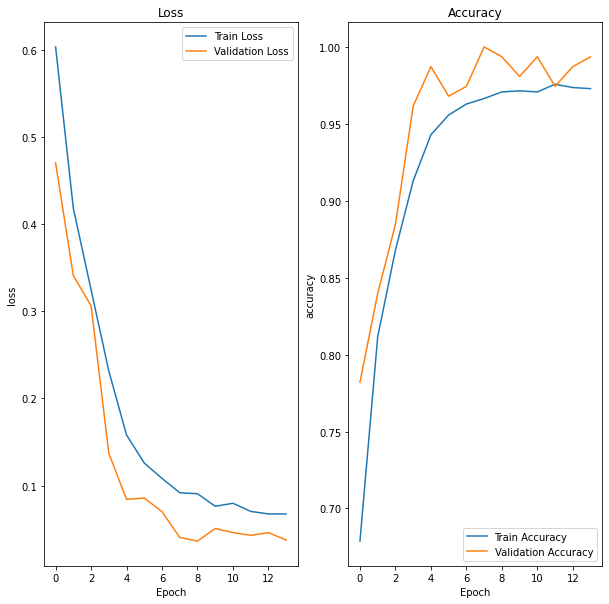

In [8]:
loss_metrics = history.history
epochs = range(len(loss_metrics['loss']))

fig, axes = plt.subplots(1,2, figsize=(10,10))

# Loss
sns.lineplot(loss_metrics, x=epochs, y='loss', label='Train Loss', ax=axes[0])
sns.lineplot(loss_metrics, x=epochs, y='val_loss', label='Validation Loss', ax=axes[0])
axes[0].set_xlabel('Epoch')
axes[0].set_title('Loss')

# Accuracy
sns.lineplot(loss_metrics, x=epochs, y='accuracy', label='Train Accuracy', ax=axes[1])
sns.lineplot(loss_metrics, x=epochs, y='val_accuracy', label='Validation Accuracy', ax=axes[1])
axes[1].set_xlabel('Epoch')
axes[1].set_title('Accuracy')

plt.show()

In [12]:
y_pred = model.predict(x_test)
y_pred = np.round(y_pred)

17/17 [==============================] - 0s 14ms/step


In [13]:
m = Accuracy()
m.update_state(y_true=y_test, y_pred=y_pred)
accuracy = m.result().numpy()
print(f'Accuracy on test set: {accuracy}')

Accuracy on test set: 0.9749518036842346


# Visualizing Activations

In [17]:
model.layers[0].name

'input_1'

In [ ]:
layers.

In [39]:
outputs = []
names = []

for layer in model.layers:
    if isinstance(layer, layers.Conv2D):
        outputs.append(layer.output)
        names.append(layer.name)
        
feature_model = Model(inputs=model.input, outputs=outputs)

In [24]:
found_bad = False
found_good = False
for i, label in enumerate(y_test):
    if label:
        bad_example = np.expand_dims(x_test[i], axis=0)
        found_good = True
        
    if not label:
        good_example = np.expand_dims(x_test[i], axis=0)
        found_bad = True
        
    if found_bad and found_good:
        break

In [40]:
good_activations = feature_model.predict(good_example)
bad_activations = feature_model.predict(bad_example)

1/1 [==============================] - 0s 10ms/step


In [38]:
len(bad_activations)

8

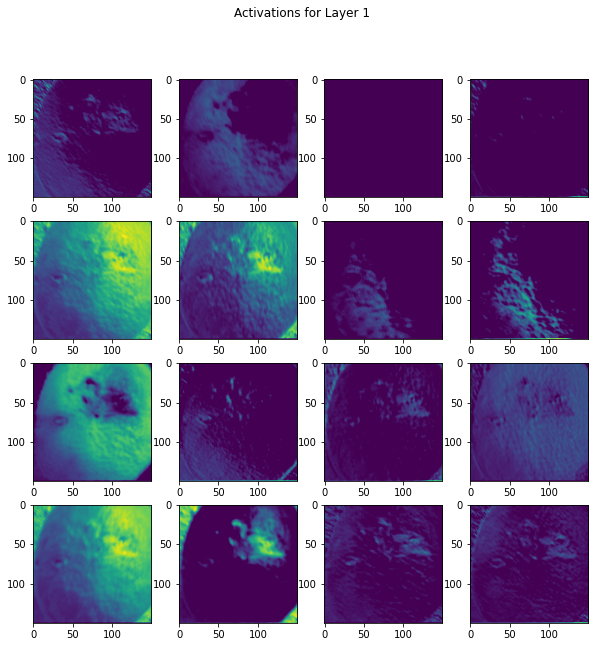

In [81]:
def plot_activations(activations, layer_num):
    num_channels = activations.shape[-1]
    activations = np.squeeze(activations)
    fig, axes = plt.subplots(4, num_channels//4, figsize=(10,10))
    
    for i, ax in zip(range(num_channels), np.ravel(axes)):
        
        ax.imshow(activations[:,:,i])
        
    fig.suptitle(f'Activations for Layer {layer_num}')
        
    plt.show()

plot_activations(good_activations[0], 1)

# Gradient Ascent

In [98]:
for layer in feature_model.layers:
    if 'conv' in layer.name:
        print(layer.name)

conv2d
conv2d_1
conv2d_2
conv2d_3


In [108]:
layer_top = feature_model.get_layer(name='conv2d')
activation_model_top = Model(feature_model.inputs, layer_top.output)

layer_bottom = feature_model.get_layer(name='conv2d_3')
activation_model_bottom = Model(feature_model.inputs, layer_bottom.output)

In [109]:
def activation_maximizer(image, idx, model):
    '''
    Used to maximize the activation of a filter at channel number "idx"
    '''
    activation = model(image)
    filter_activation = activation[:, 2:-2, 2:-2, idx]
    return K.mean(filter_activation)

In [110]:
(1,)+target_size

(1, 150, 150)

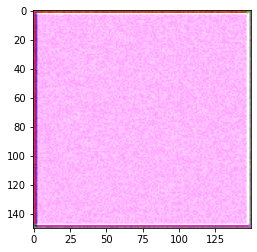

In [111]:
# Train model to maximize activations

@tf.function
def train_step(image, idx, learning_rate, model):
    with GradientTape() as tape:
        tape.watch(image)
        loss = activation_maximizer(image, idx, model)
    grads = tape.gradient(loss, image)
    grads = l2_normalize(grads)
    image += learning_rate * grads
    return image

def generate_pattern(idx, model):
    epochs = 30
    learning_rate = 10
    image = uniform(minval=0.4, maxval=0.6, shape=(1,)+target_size+(3,))
    for i in range(epochs):
        image = train_step(image, idx, learning_rate, model)
    return image[0].numpy()


image = generate_pattern(4, activation_model_top)
image = np.clip(image*255, 0, 255).astype(int)

plt.imshow(image)

In [116]:
def plot_patterns(model):
    patterns = [generate_pattern(i, model) for i in range(16)] # 16 is number of channels output by first conv layer in classifier
    
    fig, axes = plt.subplots(4, 4, figsize=(10,10))
    
    for pattern, ax in zip(patterns, np.ravel(axes)):
        pattern -= pattern.mean()
        pattern /= pattern.std()
        pattern *= 64
        pattern += 128
        pattern = np.clip(pattern, 0, 255).astype(int)[10:-10, 10:-10,:]
        ax.imshow(pattern)
        
    fig.suptitle(f'Patterns that Maximally Activate Each Channel of Fist Conv Layer in Classifier')
        
    plt.show()

Below are the patterns that most activate 16 of the channels from the first convolutional layer

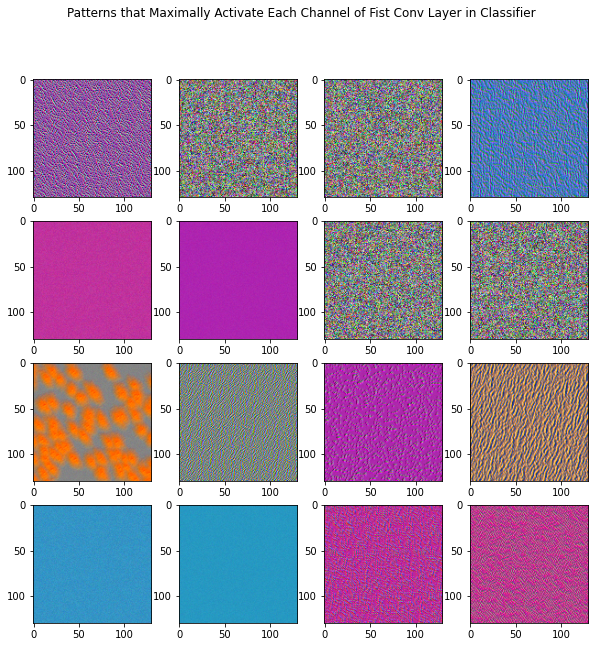

In [117]:
plot_patterns(activation_model_top)

Some of these look like skin texture, some look like white noise, and one looks a bit like mold.

Below are the patterns that maximally activate 16 of the last convolutional layer's filters

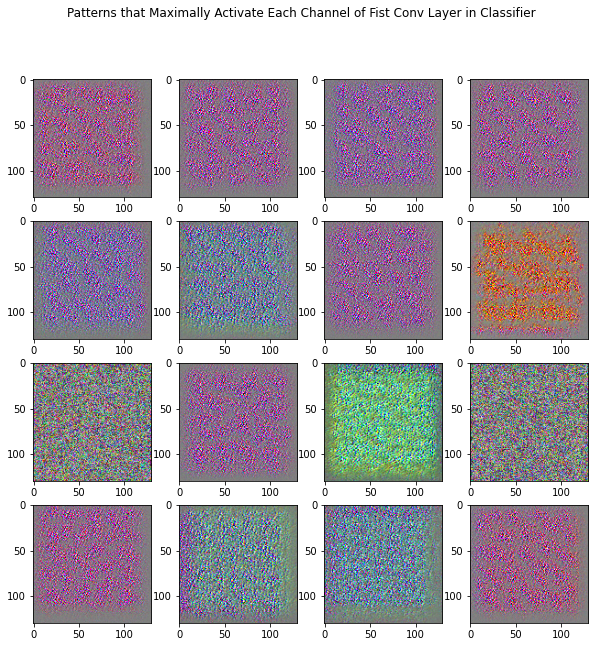

In [118]:
plot_patterns(activation_model_bottom)

As one would expect, these are even harder to interpret.